## Advantage actor-critic in AgentNet (5 pts)

Once we're done with REINFORCE, it's time to proceed with something more sophisticated.
The next one in line is advantage actor-critic, in which agent learns both policy and value function, using the latter to speed up learning.

Your main objective for this session is to... beat MountainCar-v0... with actor-critic.

Beating means making submission to [gym leaderboard](https://gym.openai.com/envs/MountainCar-v0).

``` MountainCar-v0 defines "solving" as getting average reward of -110.0 over 100 consecutive trials. ```


In [1]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
        
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


env: THEANO_FLAGS='floatX=float32'
Starting virtual X frame buffer: Xvfbstart-stop-daemon: unable to stat /usr/bin/Xvfb (No such file or directory)
.
env: DISPLAY=:1


In [2]:
import gym

env = gym.make("MountainCar-v0")
obs = env.reset()
state_size = len(obs)
n_actions = env.action_space.n
print(obs)

[2017-05-17 19:29:23,468] Making new env: MountainCar-v0


[-0.48070249  0.        ]


# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [3]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer,NonlinearityLayer,batch_norm,dropout
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,state_size))

nn = DenseLayer(observation_layer, 100)
nn = DenseLayer(nn, 250)

In [4]:
#a layer that predicts Qvalues

policy_layer = DenseLayer(nn, env.action_space.n, nonlinearity=lasagne.nonlinearities.softmax)

V_layer = DenseLayer(nn, 1, nonlinearity=None)

In [5]:
#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)

##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [6]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(policy_layer,V_layer),
              action_layers=action_layer)

In [7]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params((action_layer,V_layer),trainable=True)
weights

[W, b, W, b, W, b, W, b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [8]:
from agentnet.experiments.openai_gym.pool import EnvPool

#create a small pool with 10 parallel agents
pool = EnvPool(agent,"MountainCar-v0", n_games=10,max_size=1000) 

#we assume that pool size 1000 is small enough to learn "almost on policy" :)

[2017-05-17 19:29:24,098] Making new env: MountainCar-v0
[2017-05-17 19:29:24,102] Making new env: MountainCar-v0
[2017-05-17 19:29:24,105] Making new env: MountainCar-v0
[2017-05-17 19:29:24,108] Making new env: MountainCar-v0
[2017-05-17 19:29:24,111] Making new env: MountainCar-v0
[2017-05-17 19:29:24,114] Making new env: MountainCar-v0
[2017-05-17 19:29:24,117] Making new env: MountainCar-v0
[2017-05-17 19:29:24,120] Making new env: MountainCar-v0
[2017-05-17 19:29:24,123] Making new env: MountainCar-v0
[2017-05-17 19:29:24,126] Making new env: MountainCar-v0


In [9]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_log[:3])
print(reward_log[:3])

[[2 0 1 2 1 0 0]
 [0 2 0 2 0 2 1]
 [0 1 2 1 0 1 0]]
[[-1. -1. -1. -1. -1. -1.  0.]
 [-1. -1. -1. -1. -1. -1.  0.]
 [-1. -1. -1. -1. -1. -1.  0.]]
CPU times: user 5.55 ms, sys: 0 ns, total: 5.55 ms
Wall time: 6.14 ms


In [31]:
SEQ_LENGTH = 25
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Actor-critic loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [32]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)

_,_,_,_,(policy_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)

In [33]:
from agentnet.learning import a2c                                                   


elwise_mse_loss = a2c.get_elementwise_objective(policy_seq,
                                                V_seq[:,:,0],
                                                replay.actions[0],
                                                replay.rewards,
                                                replay.is_alive,
                                                gamma_or_gammas=0.99,
                                                n_steps=25)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

loss += 0.01*(1./(policy_seq)).sum(-1).mean()

In [34]:
from theano import tensor as T
#loss += 0.001 * (policy_seq * T.log(policy_seq)).sum(-1).mean()
#<regularize agent with negative entropy. Higher entropy = smaller loss. Multiply by small coefficient>

In [35]:
# Compute weight updates
updates = lasagne.updates.adam(loss,weights)

In [36]:
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [37]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=False)

#video is in the ./records folder

[2017-05-17 20:39:00,400] Making new env: MountainCar-v0
[2017-05-17 20:39:00,407] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-17 20:39:00,443] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/mlevkov/Practical_RL/week6/records')


Episode finished after 159 timesteps with reward=-159.0


# Training loop


In [17]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {}

In [18]:
from IPython.display import clear_output

In [ ]:
from tqdm import tqdm
#the loop may take eons to finish.
#consider interrupting early.
loss = 0
for i in tqdm(range(300000)):    
    if i % 2000 == 0:
        clear_output(True)

    #train
    pool.update(SEQ_LENGTH,append=True)
    
    loss = loss*0.99 + train_step()*0.01
        
    
    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        print("iter=%i\treward/step=%.5f\tloss ma=%.5f"%(epoch_counter,
                                                        pool_mean_reward,
                                                        loss))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,
                                               verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))

    epoch_counter  +=1

    
# Time to drink some coffee!

  9%|▊         | 26103/300000 [25:01<3:39:42, 20.78it/s]

iter=196100	reward/step=-0.99749	loss ma=32.24698


  9%|▊         | 26202/300000 [25:05<3:43:54, 20.38it/s]

iter=196200	reward/step=-0.99751	loss ma=32.26576


  9%|▉         | 26304/300000 [25:10<3:32:40, 21.45it/s]

iter=196300	reward/step=-0.99751	loss ma=32.24565


  9%|▉         | 26403/300000 [25:15<3:32:15, 21.48it/s]

iter=196400	reward/step=-0.99751	loss ma=32.31853


  9%|▉         | 26499/300000 [25:19<3:30:40, 21.64it/s][2017-05-17 21:27:05,584] Making new env: MountainCar-v0
[2017-05-17 21:27:05,587] Clearing 2 monitor files from previous run (because force=True was provided)


iter=196500	reward/step=-0.99749	loss ma=32.32195


[2017-05-17 21:27:05,902] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/mlevkov/Practical_RL/week6/records')
  9%|▉         | 26502/300000 [25:20<6:01:30, 12.61it/s]

Current score(mean over 10) = -200.000


  9%|▉         | 26604/300000 [25:25<3:33:53, 21.30it/s]

iter=196600	reward/step=-0.99756	loss ma=32.30596


  9%|▉         | 26703/300000 [25:29<3:31:06, 21.58it/s]

iter=196700	reward/step=-0.99751	loss ma=32.33053


  9%|▉         | 26802/300000 [25:34<3:30:47, 21.60it/s]

iter=196800	reward/step=-0.99749	loss ma=32.36990


  9%|▉         | 26904/300000 [25:39<3:32:37, 21.41it/s]

iter=196900	reward/step=-0.99751	loss ma=32.37630


  9%|▉         | 26997/300000 [25:43<3:33:19, 21.33it/s][2017-05-17 21:27:29,219] Making new env: MountainCar-v0
[2017-05-17 21:27:29,223] Clearing 2 monitor files from previous run (because force=True was provided)


iter=197000	reward/step=-0.99751	loss ma=32.37650


[2017-05-17 21:27:29,541] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/mlevkov/Practical_RL/week6/records')
  9%|▉         | 27003/300000 [25:43<5:17:45, 14.32it/s]

Current score(mean over 10) = -200.000


  9%|▉         | 27102/300000 [25:48<3:21:32, 22.57it/s]

iter=197100	reward/step=-0.99749	loss ma=32.37730


  9%|▉         | 27204/300000 [25:53<3:34:06, 21.23it/s]

iter=197200	reward/step=-0.99749	loss ma=32.35072


  9%|▉         | 27303/300000 [25:57<3:34:17, 21.21it/s]

iter=197300	reward/step=-0.99751	loss ma=32.34483


  9%|▉         | 27402/300000 [26:02<3:32:54, 21.34it/s]

iter=197400	reward/step=-0.99749	loss ma=32.35059


  9%|▉         | 27498/300000 [26:06<3:33:07, 21.31it/s][2017-05-17 21:27:52,707] Making new env: MountainCar-v0
[2017-05-17 21:27:52,710] Clearing 2 monitor files from previous run (because force=True was provided)


iter=197500	reward/step=-0.99749	loss ma=32.36172


[2017-05-17 21:27:53,027] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/mlevkov/Practical_RL/week6/records')
  9%|▉         | 27504/300000 [26:07<5:14:03, 14.46it/s]

Current score(mean over 10) = -200.000


  9%|▉         | 27602/300000 [26:12<3:43:38, 20.30it/s]

iter=197600	reward/step=-0.99749	loss ma=32.35194


  9%|▉         | 27611/300000 [26:12<3:43:54, 20.28it/s]

In [39]:
iters,session_rewards=list(zip(*sorted(rewards.items(),key=lambda x:x[0])))

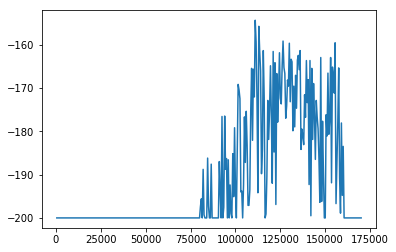

In [40]:
plt.plot(iters,list(map(np.mean,session_rewards)))

### Visualizing the $V(s)$ and  $\pi(a|s)$

Since the observation space is just 2-dimensional, we can plot it on a 2d scatter-plot to gain insight of what agent learned.

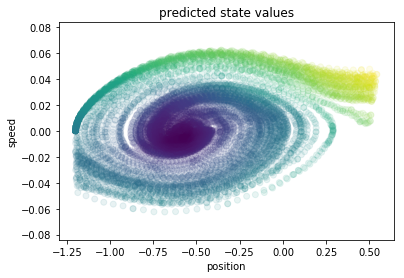

In [25]:
_,_,_,_,(pool_policy,pool_V) = agent.get_sessions(
    pool.experience_replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,)

plt.scatter(
    *pool.experience_replay.observations[0].get_value().reshape([-1,2]).T,
    c = pool_V.ravel().eval(),
    alpha = 0.1)
plt.title("predicted state values")
plt.xlabel("position")
plt.ylabel("speed")

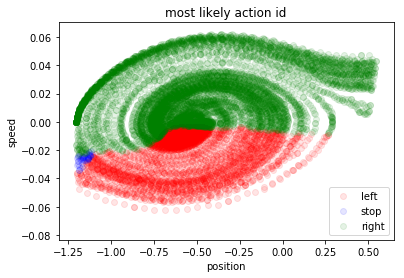

In [26]:
obs_x,obs_y = pool.experience_replay.observations[0].get_value().reshape([-1,2]).T
optimal_actid = pool_policy.argmax(-1).ravel().eval()
action_names=["left","stop","right"]
for i in range(3):
    sel = optimal_actid==i
    plt.scatter(obs_x[sel],obs_y[sel],
                c=['red','blue','green'][i],
                alpha = 0.1,label=action_names[i])
    
plt.title("most likely action id")
plt.xlabel("position")
plt.ylabel("speed")
plt.legend(loc='best')

### Variations in the algorithm (2 pts)

Try different `n_steps` param to see if it improves learning performance.

Your objective is to compare learning curves for 1, 3, 10 and 25-step updates (or any grid you think is appropriate).

For 25-step updates, please also increase SEQ_LENGTH to 25.

Also evaluate how performance changes with different entropy regularizer coefficient.

_bonus_ See if you can learn effectively without experience replay (may need a lot of parallel agents)

In [ ]:
#<a lot of your code here>

### Bonus section (5+ pts)

Beat the [`LunarLanderContinuous-v2`](https://gym.openai.com/envs/LunarLanderContinuous-v2) with continuous version of advantage actor-critic.

You will require a multidimensional gaussian (or similar) policy from your agent.

You can implement that by feeding a2c.get_elementwise_objective probabilities of agent's chosen actions (it will be 2-dimensional) instead of all actions.

Contact us if you have any questions.